<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Note: This notebook is a work in progress & will be updated continuously over the next week or so before it's ready - 18 May 2021

# Time series forecasting in TensorFlow

The goal of this notebook is to get you familiar with working with time series data.

It won't cover all of the time series field but by the end you will get a fairly good overview of things to consider for time series problems...

Outline:
* Get data (a time series)
* Format data
  * Turn data into a windowed dataset
  * Training/test sets for time series
  * Univariate - Bitcoin's price history
  * Multivariate - Bitcoin's price history + block size
* Model data
  * Baseline - naive forecasting
  * Baseline 2 - moving average
  * Baseline 3 - random forest regressor
  * Deep model - fully connected
  * Sequence models
    * LSTM
    * Conv1D
  * N-Beats algorithm - https://arxiv.org/pdf/1905.10437.pdf
* Evaluating a time series model
  * MAE
  * MSE
  * RMSE etc...
* Uncertainty estimates
  * Coconut uncertainty - epistemic uncertainty
  * Subway uncertainty - aleatory uncertainty
* Why forecasting is BS (turkey problem) - https://youtu.be/hRwimmE2wEk
  * Open system: beware (like fortune telling), see Mark Saroufim's tweet - https://twitter.com/marksaroufim/status/1366871736604532739?s=20 
  * Closed system: try it out 
* Exercises
* Extra-curriculum
  * Time series book - https://otexts.com/fpp2/accuracy.html 


## TODO: What is a time series problem?

* Forecasting
* Classification

## TODO: Get data

Let's predict the price of Bitcoin!

> **Note:** This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

See this tweet for reference: https://twitter.com/marksaroufim/status/1366871736604532739?s=20

TODO (upload to Google Storage/GitHub): Data: https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv?dl=0

In [3]:
!wget https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-05-18 01:19:48--  https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv [following]
--2021-05-18 01:19:48--  https://www.dropbox.com/s/raw/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9a7c032627d04815b7ae688e13.dl.dropboxusercontent.com/cd/0/inline/BOvxGkLQHuhHVbuvVuu9_4tXP0v0-SqyRkIzeSdTqsBCvbZfLUTqZW6Ul1KoMIBvFea5ciFGQKeD1-oJI3IURANbF-WZDWw7uxxnGg5XgvtJ_ZBiCXdTNR1Wf0YsZC95S0JsS6fN2esYipVdWfi7pI59/file# [following]
--2021-05-18 01:19:49--  https://uc9a7c032627d04815b7ae688e13.dl.dropboxusercontent.com/cd/0/inli

In [85]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [89]:
# Only want closing price
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [90]:
bitcoin_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2787 non-null   float64
dtypes: float64(1)
memory usage: 43.5 KB


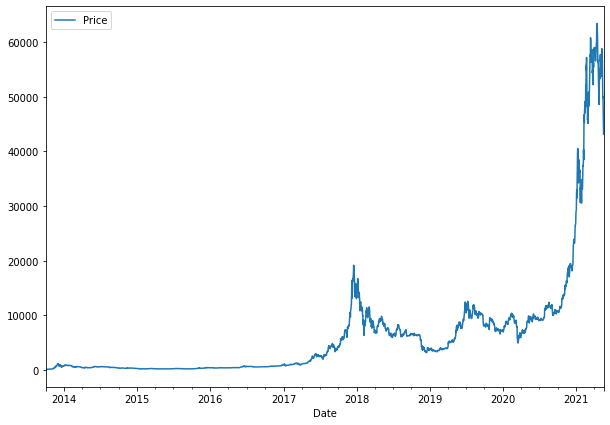

In [91]:
bitcoin_prices.plot(figsize=(10, 7));

In [162]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [163]:
# Windowing data
bitcoin_prices["Shift+1"] = bitcoin_prices["Price"].shift(1)
bitcoin_prices.head()

,Price,Shift+1
Date,,
2013-10-01,123.65499,NaN
2013-10-02,125.45500,123.65499
2013-10-03,108.58483,125.45500
2013-10-04,118.67466,108.58483
2013-10-05,121.33866,118.67466


### Importing time series as a CSV

In [63]:
# Importing with Python CSV - https://realpython.com/python-csv/
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

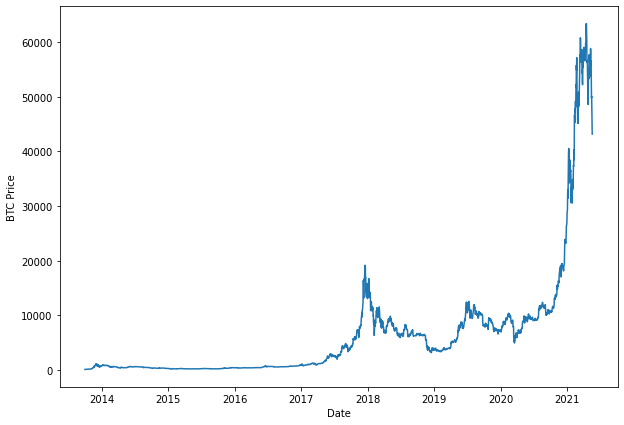

In [68]:
# Plot from CSV
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(timesteps, np.array(btc_price))
plt.xlabel("Date")
plt.ylabel("BTC Price");

## TODO: Format data 

* Turn data into a windowed dataset
* Training/test sets for time series
* Univariate - Bitcoin's price history
* Multivariate - Bitcoin's price history + block size

### TODO: Create train & test sets for time series

* Note: cannot do random split, time series will buckle under this (using future values in the past)
* Need to make train set: values from past, test set: values from "future"

In [109]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [110]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2229,), (558,), (2229,), (558,))

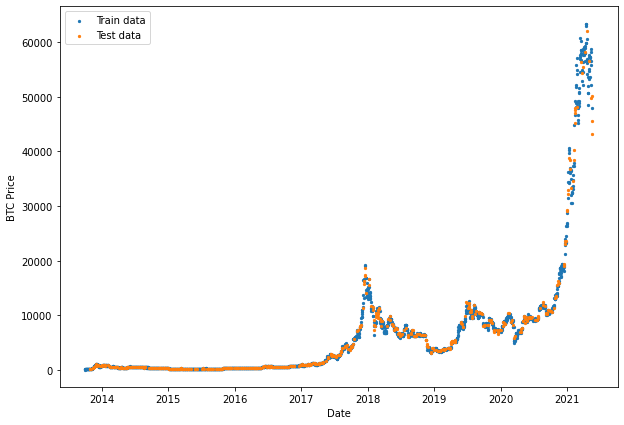

In [111]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend()
plt.show();

* TODO: Note: time series forecasting can often have many less data points than traditional deep learning projects (e.g. the entire history of BTC daily price data = only ~3000 samples)

* TODO: What kind of steps should we predict? E.g. 80/20 split is that realisitic? You may want to use all of the data up until the last week...

In [113]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

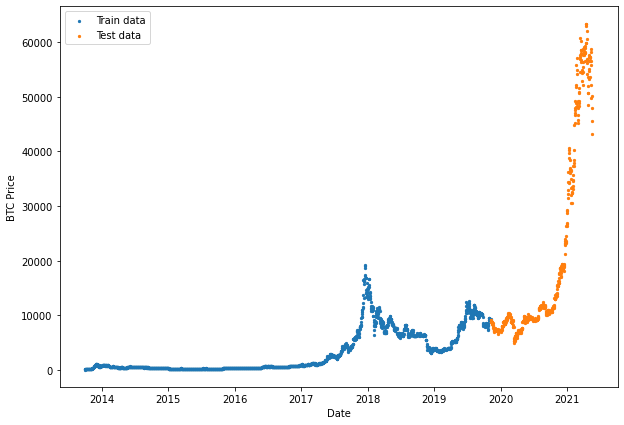

In [115]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend()
plt.show();

## TODO: Model data

* Baseline - naive forecasting
* Baseline 2 - moving average
* Baseline 3 - random forest regressor
* Deep model - fully connected
* Sequence models
* LSTM
* Conv1D
* N-Beats algorithm - https://arxiv.org/pdf/1905.10437.pdf

### Model_0: Naive forecast

Naive forecast = Use the previous timestep to predict the next timestep

$$\hat{y}_{t} = y_{t-1}$$ 

In [119]:
naive_forecast = y_test[:-1]
naive_forecast[:10]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 ])

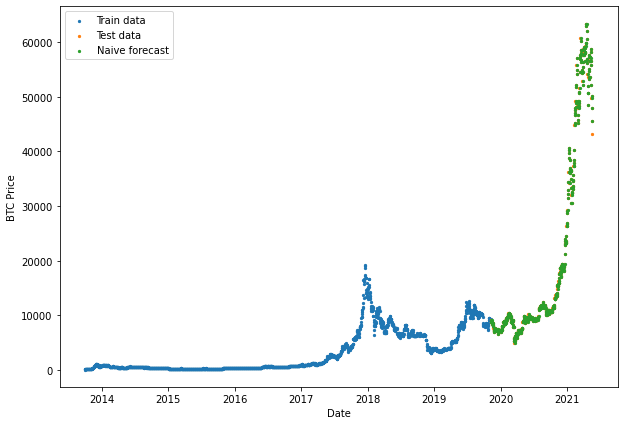

In [121]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.scatter(X_test[1:], naive_forecast, s=5, label="Naive forecast")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend()
plt.show();

In [128]:
def plot_zoomed_in(new_preds=None, new_preds_name="New Preds", zoom_timesteps=100):
  # Plot naive forecast zoomed in
  plt.figure(figsize=(10, 7))
  plt.plot(X_test[-zoom_timesteps:], y_test[-zoom_timesteps:], label="Test data")
  plt.plot(X_test[1:][-zoom_timesteps:], naive_forecast[-zoom_timesteps:], label="Naive forecast")
  if new_preds:
    plt.plot(X_test[-zoom_timesteps:], new_preds[-zoom_timesteps:], label=new_preds_name)
  plt.xlabel("Date")
  plt.ylabel("BTC Price")
  plt.legend()
  plt.show();

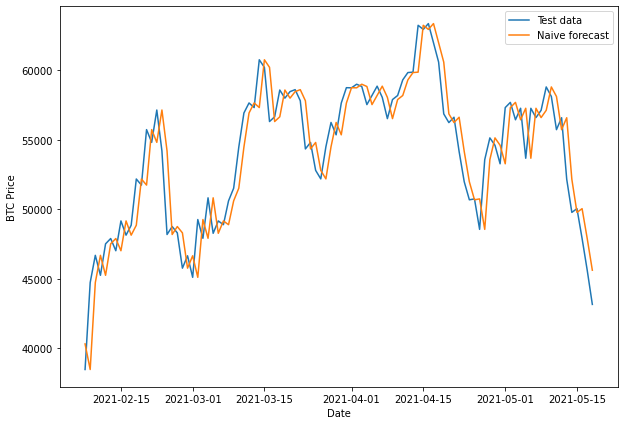

In [129]:
plot_zoomed_in()

## TODO: Evaluating a time series model

TK - this can be a function for each model (compares predictions to ground truth...)

In [132]:
import tensorflow as tf

In [133]:
def scaled_mape(y_true, y_pred):
  return tf.reduce_mean(200 * (tf.abs(y_true - y_pred)/(tf.abs(y_true) + tf.abs(y_pred))))

In [134]:
def evaluate_preds(y_true, y_pred, use_window=True, window_size=10):
  # TODO: does this need to go from Numpy -> tensorflow -> Numpy??
  # TODO: could use sklearn to fix the above

  # Account for window size
  if use_window:
    y_true = y_true[window_size:]
  
  # Turn into tensors
  y_true = tf.constant(y_true, dtype=tf.float32)
  y_pred = tf.constant(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  smape = scaled_mape(y_true, y_pred)
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "mape": mape.numpy(),
          "smape": smape.numpy()}

In [137]:
evaluate_preds(y_true=y_test[1:],
               y_pred=naive_forecast,
               use_window=False)

{'mae': 567.9802, 'mape': 2.516525, 'mse': 1147547.0, 'smape': 2.5180573}

In [ ]:
# TODO: Make evaluation function for various metrics...

## Windowing dataset

Why do we window?

We can turn our time series data into a supervised learning problem: use windows of the past to predict the future.

In [138]:
X_train, y_train

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', ...,
        '2019-11-05T00:00:00.000000000', '2019-11-06T00:00:00.000000000',
        '2019-11-07T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([ 123.65499   ,  125.455     ,  108.58483   , ..., 9369.62808116,
        9326.59962378, 9335.75240233]))

In [140]:
X_test[:10], y_test[:10]

(array(['2019-11-08T00:00:00.000000000', '2019-11-09T00:00:00.000000000',
        '2019-11-10T00:00:00.000000000', '2019-11-11T00:00:00.000000000',
        '2019-11-12T00:00:00.000000000', '2019-11-13T00:00:00.000000000',
        '2019-11-14T00:00:00.000000000', '2019-11-15T00:00:00.000000000',
        '2019-11-16T00:00:00.000000000', '2019-11-17T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]))

Want:

```
# Window for a week (univariate time series)
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [165]:
len(y_train)

2229

In [168]:
round(len(y_train)/10)

223

In [177]:
# Make windows of training data
window_X = np.array(np.split(y_train[:2220], round(len(y_train)/10)-1))
window_X[0], window_X[1][0]

(array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]), 125.27966)

In [178]:
window_X[1]

array([125.27966, 125.9275 , 126.38333, 135.24199, 133.20333, 142.76333,
       137.92333, 142.95166, 152.55183, 160.33883])

In [179]:
# Next: 
# Get labels from above array
# Take the first element of the next element to create the windowed dataset
# Can a lambda function or fancy indexing be used here?

In [144]:
def extract_windows_vectorized(array, clearing_time_index, max_time, sub_window_size):
    start = clearing_time_index + 1 - sub_window_size + 1
    
    sub_windows = (
        start +
        # expand_dims are used to convert a 1D array to 2D array.
        np.expand_dims(np.arange(sub_window_size), 0) +
        np.expand_dims(np.arange(max_time + 1), 0).T
    )
    
    return array[sub_windows]

In [151]:
X_rand = np.random.randn(10000, 200)
A = extract_windows_vectorized(X_rand,
                               clearing_time_index=3,
                               max_time=1200,
                               sub_window_size=3)
A

array([[[ 0.65497685, -0.4040274 ,  1.57800403, ..., -0.12355104,
         -2.66550649, -0.53243981],
        [-0.77303711, -0.82215383,  0.59948422, ..., -0.32188406,
          0.42009943,  0.66261718],
        [ 0.11160699, -0.5873858 , -0.5388539 , ..., -0.73868516,
          0.00868863, -0.78103393]],

       [[-0.77303711, -0.82215383,  0.59948422, ..., -0.32188406,
          0.42009943,  0.66261718],
        [ 0.11160699, -0.5873858 , -0.5388539 , ..., -0.73868516,
          0.00868863, -0.78103393],
        [-0.46806705,  1.06807198, -0.31058024, ...,  0.25848829,
          0.85341998,  1.81219867]],

       [[ 0.11160699, -0.5873858 , -0.5388539 , ..., -0.73868516,
          0.00868863, -0.78103393],
        [-0.46806705,  1.06807198, -0.31058024, ...,  0.25848829,
          0.85341998,  1.81219867],
        [ 0.2262    , -1.33956141,  0.61254906, ...,  0.51691522,
         -1.31697944,  0.26173615]],

       ...,

       [[-2.10101667, -0.21229312, -0.49394359, ..., -2.1184534

### TODO: Model 1: Moving average

### TODO: Model 2: Random Forest Regressor

In [ ]:
# TODO: Use entire time series to predict next step, compare to actual data 
# (e.g. revisit the prices in 1 week & see how the model goes)
# Start date: 18 May 2021
# End date: 25 May 2021 (revisit the updated prices here & see how wrong the model is...)

## TODO: Uncertainty estimates

# TODO: Why forecasting is BS (turkey problem)

TK - inject a turkey problem piece of data into the model & see how it effects (e.g. 1 data point that's 50x of outlier)

* See this video: https://youtu.be/hRwimmE2wEk
* Open system: beware (like fortune telling), see Mark Saroufim's tweet - https://twitter.com/marksaroufim/status/1366871736604532739?s=20
* Closed system: try it out

# TODO: Exercises

## TODO: Extra-curriculum